In [1]:
import os
import sys

module_path = os.path.abspath(os.path.join('../..'))

if module_path not in sys.path:
    sys.path.append(module_path)


import pandas as pd
import numpy as np
import matplotlib.pyplot as plt


from math import sqrt
from tensorflow import keras
from sklearn.metrics import mean_squared_error as mse
from sklearn.metrics import mean_absolute_error as mae
from tensorflow.keras.models import load_model
from tensorflow.keras.layers import *
from tensorflow.keras.models import *
from tensorflow.keras.optimizers import *
from tensorflow.keras.callbacks import *


from preprocess import water_process
# from model.cnn import cnn_4layer, mlp_layer
from model.mlp import mlp_layer

2024-01-12 18:39:19.870569: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudart.so.10.1


In [2]:
import os
os.environ["CUDA_VISIBLE_DEVICES"] = "1"

### Preprocess

In [3]:
# ====== preprocessing parameters ======
n_hours = 72
k = 24 
masked_value = 1e-10
split_1 = 0.7
split_2 = 0.85

In [4]:
train_X_mask, val_X_mask, test_X_mask, \
train_ws_y, val_ws_y, test_ws_y, \
scaler, ws_scaler = water_process(n_hours, k, masked_value, split_1, split_2)

Index(['MEAN_RAIN', 'WS_S4', 'GATE_S25A', 'GATE_S25B', 'GATE_S25B2',
       'GATE_S26_1', 'GATE_S26_2', 'PUMP_S25B', 'PUMP_S26', 'HWS_S25A',
       'HWS_S25B', 'HWS_S26', 'WS_S1', 'TWS_S25A', 'TWS_S25B', 'TWS_S26'],
      dtype='object')


In [5]:
print(train_X_mask.shape, val_X_mask.shape, test_X_mask.shape, train_ws_y.shape, val_ws_y.shape, test_ws_y.shape)

(67435, 96, 16) (14451, 96, 16) (14451, 96, 16) (67435, 96) (14451, 96) (14451, 96)


### Reweighting

In [28]:
# train_X_mask_rain_acc = np.sum(train_X_mask[:, -24:, 0], axis=1)
# print(train_X_mask_rain_acc.shape)

# test_X_mask_rain_acc = np.sum(test_X_mask[:, -24:, 0], axis=1)
# print(test_X_mask_rain_acc.shape)

train_X_mask_rain_acc = train_X_mask[:, 0, 0]
print(train_X_mask_rain_acc.shape)

val_X_mask_rain_acc = val_X_mask[:, 0, 0]
print(val_X_mask_rain_acc.shape)

test_X_mask_rain_acc = test_X_mask[:, 0, 0]
print(test_X_mask_rain_acc.shape)

(67435,)
(14451,)
(14451,)


In [39]:
bin_nums = 20

# Step 1: Calculate the histogram
counts, bin_edges = np.histogram(train_X_mask_rain_acc, bins=bin_nums)

# Step 2: Invert counts to assign lower weights to more frequent bins, avoid division by zero by adding a small number (epsilon)
epsilon = 1e-8
weights = np.sqrt(1.0 / (counts + epsilon))

# Step 3: Normalize the weights (optional)
weights /= np.sum(weights) * len(counts)

# Step 4: Assign weights to each sample based on the bin it falls into
sample_weights = np.zeros(train_X_mask_rain_acc.shape[0])

for i, value in enumerate(train_X_mask_rain_acc):
    
    # Find the index of the bin this sample falls into
    bin_index = np.digitize(value, bin_edges) - 1
    bin_index = min(bin_index, bin_nums - 1)
    
    # Assign the corresponding weight
    sample_weights[i] = weights[bin_index]

In [40]:
sample_weights.shape

(67435,)

In [42]:
# sample_weights /= np.max(sample_weights)
# sample_weights /= np.sum(sample_weights)
sample_weights = (sample_weights - sample_weights.min()) / (sample_weights.max()-sample_weights.min()) + 0.1

In [43]:
sample_weights

array([0.1       , 0.1       , 0.1       , ..., 0.16273383, 0.1       ,
       0.1       ])

In [44]:
np.save('ws_sample_weights_IPF.npy', sample_weights)

(array([6.6943e+04, 3.3700e+02, 5.9000e+01, 3.6000e+01, 2.3000e+01,
        0.0000e+00, 9.0000e+00, 8.0000e+00, 6.0000e+00, 0.0000e+00,
        0.0000e+00, 9.0000e+00, 0.0000e+00, 0.0000e+00, 2.0000e+00,
        0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 3.0000e+00]),
 array([0.1 , 0.15, 0.2 , 0.25, 0.3 , 0.35, 0.4 , 0.45, 0.5 , 0.55, 0.6 ,
        0.65, 0.7 , 0.75, 0.8 , 0.85, 0.9 , 0.95, 1.  , 1.05, 1.1 ]),
 <BarContainer object of 20 artists>)

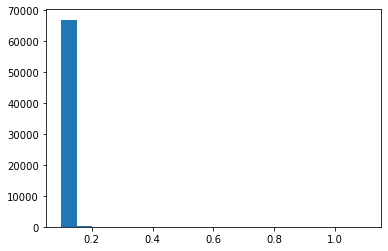

In [45]:
plt.hist(sample_weights, bins=20)

### Model

In [46]:
# ===== model parameters ======
mlp_unit1 = 128
mlp_unit2 = 128
mlp_unit3 = 64
mlp_unit4 = 64
mlp_unit5 = 32
mlp_unit6 = 32
mlp_unit7 = 16
mlp_unit8 = 16
dropout = 0.0  # 0.1
kernel_size = 2
pool_size = 2
learning_rate = 1e-4
decay_steps = 10000
decay_rate = 0.95
PATIENCE = 100
EPOCHS = 1000
BATCH = 512
opt_num = k*4
input_shape = train_X_mask.shape[1:]

In [47]:
model = mlp_layer(input_shape=input_shape,
                   mlp_unit1=mlp_unit1,
                   mlp_unit2=mlp_unit2,
                   mlp_unit3=mlp_unit3,
                   mlp_unit4=mlp_unit4,
                   mlp_unit5=mlp_unit5,
                   mlp_unit6=mlp_unit6,
                   mlp_unit7=mlp_unit7,
                   mlp_unit8=mlp_unit8,
                   dropout=dropout,
                   masked_value=-1,
                   opt_num=opt_num
                  )
# model.summary()

In [48]:
lr_schedule = keras.optimizers.schedules.ExponentialDecay(initial_learning_rate=learning_rate, 
                                                          decay_steps=decay_steps,
                                                          decay_rate=decay_rate)

model.compile(optimizer=Adam(learning_rate=lr_schedule),
              loss='mse',
              metrics=['mae']
             )


es = EarlyStopping(monitor='val_mae', mode='min', verbose=2, patience=PATIENCE)
mc = ModelCheckpoint('../../saved_models/water_all_weighted_IPF_95.h5', 
                     monitor='val_mae', 
                     mode='min', 
                     verbose=2, 
                     save_best_only=True,
                    )


model.fit([train_X_mask], train_ws_y,
          validation_data=([val_X_mask], val_ws_y),
          epochs=EPOCHS,
          batch_size=BATCH,
          verbose=2,
          shuffle=True,
          callbacks=[es, mc],
          sample_weight=sample_weights
         )

Epoch 1/1000
132/132 - 3s - loss: 0.0044 - mae: 0.1624 - val_loss: 0.0246 - val_mae: 0.1319

Epoch 00001: val_mae improved from inf to 0.13191, saving model to ../../saved_models/water_weighted.h5
Epoch 2/1000
132/132 - 2s - loss: 9.3475e-04 - mae: 0.0787 - val_loss: 0.0055 - val_mae: 0.0592

Epoch 00002: val_mae improved from 0.13191 to 0.05921, saving model to ../../saved_models/water_weighted.h5
Epoch 3/1000
132/132 - 2s - loss: 1.7655e-04 - mae: 0.0318 - val_loss: 0.0032 - val_mae: 0.0454

Epoch 00003: val_mae improved from 0.05921 to 0.04544, saving model to ../../saved_models/water_weighted.h5
Epoch 4/1000
132/132 - 2s - loss: 1.3604e-04 - mae: 0.0278 - val_loss: 0.0030 - val_mae: 0.0437

Epoch 00004: val_mae improved from 0.04544 to 0.04369, saving model to ../../saved_models/water_weighted.h5
Epoch 5/1000
132/132 - 2s - loss: 1.1982e-04 - mae: 0.0259 - val_loss: 0.0029 - val_mae: 0.0429

Epoch 00005: val_mae improved from 0.04369 to 0.04294, saving model to ../../saved_models/w


Epoch 00043: val_mae improved from 0.02585 to 0.02551, saving model to ../../saved_models/water_weighted.h5
Epoch 44/1000
132/132 - 2s - loss: 1.9763e-05 - mae: 0.0086 - val_loss: 9.4918e-04 - val_mae: 0.0252

Epoch 00044: val_mae improved from 0.02551 to 0.02517, saving model to ../../saved_models/water_weighted.h5
Epoch 45/1000
132/132 - 2s - loss: 1.9517e-05 - mae: 0.0086 - val_loss: 9.6296e-04 - val_mae: 0.0253

Epoch 00045: val_mae did not improve from 0.02517
Epoch 46/1000
132/132 - 2s - loss: 1.9287e-05 - mae: 0.0085 - val_loss: 9.9426e-04 - val_mae: 0.0259

Epoch 00046: val_mae did not improve from 0.02517
Epoch 47/1000
132/132 - 2s - loss: 1.9080e-05 - mae: 0.0085 - val_loss: 8.7417e-04 - val_mae: 0.0242

Epoch 00047: val_mae improved from 0.02517 to 0.02417, saving model to ../../saved_models/water_weighted.h5
Epoch 48/1000
132/132 - 2s - loss: 1.8863e-05 - mae: 0.0084 - val_loss: 9.4467e-04 - val_mae: 0.0252

Epoch 00048: val_mae did not improve from 0.02417
Epoch 49/1000
1

132/132 - 2s - loss: 1.4362e-05 - mae: 0.0072 - val_loss: 7.0505e-04 - val_mae: 0.0216

Epoch 00091: val_mae did not improve from 0.02075
Epoch 92/1000
132/132 - 2s - loss: 1.4299e-05 - mae: 0.0072 - val_loss: 6.6084e-04 - val_mae: 0.0210

Epoch 00092: val_mae did not improve from 0.02075
Epoch 93/1000
132/132 - 2s - loss: 1.4246e-05 - mae: 0.0071 - val_loss: 6.7215e-04 - val_mae: 0.0211

Epoch 00093: val_mae did not improve from 0.02075
Epoch 94/1000
132/132 - 2s - loss: 1.4225e-05 - mae: 0.0071 - val_loss: 7.1535e-04 - val_mae: 0.0218

Epoch 00094: val_mae did not improve from 0.02075
Epoch 95/1000
132/132 - 2s - loss: 1.4182e-05 - mae: 0.0071 - val_loss: 6.8237e-04 - val_mae: 0.0213

Epoch 00095: val_mae did not improve from 0.02075
Epoch 96/1000
132/132 - 2s - loss: 1.4183e-05 - mae: 0.0071 - val_loss: 7.2004e-04 - val_mae: 0.0219

Epoch 00096: val_mae did not improve from 0.02075
Epoch 97/1000
132/132 - 2s - loss: 1.4125e-05 - mae: 0.0071 - val_loss: 6.9239e-04 - val_mae: 0.0214




Epoch 00143: val_mae did not improve from 0.02023
Epoch 144/1000
132/132 - 2s - loss: 1.2477e-05 - mae: 0.0066 - val_loss: 6.3647e-04 - val_mae: 0.0204

Epoch 00144: val_mae did not improve from 0.02023
Epoch 145/1000
132/132 - 2s - loss: 1.2433e-05 - mae: 0.0066 - val_loss: 6.7701e-04 - val_mae: 0.0212

Epoch 00145: val_mae did not improve from 0.02023
Epoch 146/1000
132/132 - 2s - loss: 1.2385e-05 - mae: 0.0066 - val_loss: 6.2393e-04 - val_mae: 0.0202

Epoch 00146: val_mae did not improve from 0.02023
Epoch 147/1000
132/132 - 2s - loss: 1.2356e-05 - mae: 0.0066 - val_loss: 6.2113e-04 - val_mae: 0.0201

Epoch 00147: val_mae improved from 0.02023 to 0.02014, saving model to ../../saved_models/water_weighted.h5
Epoch 148/1000
132/132 - 2s - loss: 1.2313e-05 - mae: 0.0066 - val_loss: 6.4623e-04 - val_mae: 0.0206

Epoch 00148: val_mae did not improve from 0.02014
Epoch 149/1000
132/132 - 2s - loss: 1.2313e-05 - mae: 0.0066 - val_loss: 6.3608e-04 - val_mae: 0.0204

Epoch 00149: val_mae di

132/132 - 2s - loss: 1.1194e-05 - mae: 0.0062 - val_loss: 6.6269e-04 - val_mae: 0.0208

Epoch 00197: val_mae did not improve from 0.02014
Epoch 198/1000
132/132 - 2s - loss: 1.1138e-05 - mae: 0.0062 - val_loss: 6.7170e-04 - val_mae: 0.0211

Epoch 00198: val_mae did not improve from 0.02014
Epoch 199/1000
132/132 - 2s - loss: 1.1159e-05 - mae: 0.0062 - val_loss: 6.9099e-04 - val_mae: 0.0213

Epoch 00199: val_mae did not improve from 0.02014
Epoch 200/1000
132/132 - 2s - loss: 1.1081e-05 - mae: 0.0062 - val_loss: 6.4659e-04 - val_mae: 0.0206

Epoch 00200: val_mae did not improve from 0.02014
Epoch 201/1000
132/132 - 2s - loss: 1.1089e-05 - mae: 0.0062 - val_loss: 6.9133e-04 - val_mae: 0.0213

Epoch 00201: val_mae did not improve from 0.02014
Epoch 202/1000
132/132 - 2s - loss: 1.1119e-05 - mae: 0.0062 - val_loss: 6.6872e-04 - val_mae: 0.0210

Epoch 00202: val_mae did not improve from 0.02014
Epoch 203/1000
132/132 - 2s - loss: 1.1066e-05 - mae: 0.0062 - val_loss: 6.4370e-04 - val_mae: 0.


Epoch 00250: val_mae did not improve from 0.01996
Epoch 251/1000
132/132 - 2s - loss: 1.0190e-05 - mae: 0.0059 - val_loss: 6.5217e-04 - val_mae: 0.0205

Epoch 00251: val_mae did not improve from 0.01996
Epoch 252/1000
132/132 - 2s - loss: 1.0225e-05 - mae: 0.0059 - val_loss: 7.0600e-04 - val_mae: 0.0214

Epoch 00252: val_mae did not improve from 0.01996
Epoch 253/1000
132/132 - 2s - loss: 1.0207e-05 - mae: 0.0059 - val_loss: 6.5349e-04 - val_mae: 0.0205

Epoch 00253: val_mae did not improve from 0.01996
Epoch 254/1000
132/132 - 2s - loss: 1.0177e-05 - mae: 0.0059 - val_loss: 6.6580e-04 - val_mae: 0.0207

Epoch 00254: val_mae did not improve from 0.01996
Epoch 255/1000
132/132 - 2s - loss: 1.0228e-05 - mae: 0.0059 - val_loss: 6.5883e-04 - val_mae: 0.0207

Epoch 00255: val_mae did not improve from 0.01996
Epoch 256/1000
132/132 - 2s - loss: 1.0092e-05 - mae: 0.0059 - val_loss: 6.6061e-04 - val_mae: 0.0206

Epoch 00256: val_mae did not improve from 0.01996
Epoch 257/1000
132/132 - 2s - l


Epoch 00304: val_mae did not improve from 0.01996
Epoch 305/1000
132/132 - 2s - loss: 9.5589e-06 - mae: 0.0057 - val_loss: 6.4298e-04 - val_mae: 0.0201

Epoch 00305: val_mae did not improve from 0.01996
Epoch 306/1000
132/132 - 2s - loss: 9.6257e-06 - mae: 0.0057 - val_loss: 6.5408e-04 - val_mae: 0.0203

Epoch 00306: val_mae did not improve from 0.01996
Epoch 307/1000
132/132 - 2s - loss: 9.4807e-06 - mae: 0.0056 - val_loss: 6.2703e-04 - val_mae: 0.0198

Epoch 00307: val_mae improved from 0.01996 to 0.01985, saving model to ../../saved_models/water_weighted.h5
Epoch 308/1000
132/132 - 2s - loss: 9.5185e-06 - mae: 0.0057 - val_loss: 6.8288e-04 - val_mae: 0.0207

Epoch 00308: val_mae did not improve from 0.01985
Epoch 309/1000
132/132 - 2s - loss: 9.4946e-06 - mae: 0.0057 - val_loss: 6.3101e-04 - val_mae: 0.0198

Epoch 00309: val_mae did not improve from 0.01985
Epoch 310/1000
132/132 - 2s - loss: 9.5109e-06 - mae: 0.0057 - val_loss: 6.6259e-04 - val_mae: 0.0203

Epoch 00310: val_mae di


Epoch 00355: val_mae did not improve from 0.01912
Epoch 356/1000
132/132 - 2s - loss: 9.0535e-06 - mae: 0.0055 - val_loss: 6.1775e-04 - val_mae: 0.0194

Epoch 00356: val_mae did not improve from 0.01912
Epoch 357/1000
132/132 - 2s - loss: 9.0499e-06 - mae: 0.0055 - val_loss: 6.0706e-04 - val_mae: 0.0192

Epoch 00357: val_mae did not improve from 0.01912
Epoch 358/1000
132/132 - 2s - loss: 9.1049e-06 - mae: 0.0055 - val_loss: 5.9211e-04 - val_mae: 0.0190

Epoch 00358: val_mae improved from 0.01912 to 0.01895, saving model to ../../saved_models/water_weighted.h5
Epoch 359/1000
132/132 - 2s - loss: 9.0307e-06 - mae: 0.0055 - val_loss: 6.1585e-04 - val_mae: 0.0193

Epoch 00359: val_mae did not improve from 0.01895
Epoch 360/1000
132/132 - 2s - loss: 9.0225e-06 - mae: 0.0055 - val_loss: 6.2173e-04 - val_mae: 0.0194

Epoch 00360: val_mae did not improve from 0.01895
Epoch 361/1000
132/132 - 2s - loss: 9.0912e-06 - mae: 0.0055 - val_loss: 6.2797e-04 - val_mae: 0.0195

Epoch 00361: val_mae di


Epoch 00406: val_mae did not improve from 0.01829
Epoch 407/1000
132/132 - 2s - loss: 8.7146e-06 - mae: 0.0053 - val_loss: 5.8909e-04 - val_mae: 0.0185

Epoch 00407: val_mae did not improve from 0.01829
Epoch 408/1000
132/132 - 2s - loss: 8.6997e-06 - mae: 0.0053 - val_loss: 5.9337e-04 - val_mae: 0.0185

Epoch 00408: val_mae did not improve from 0.01829
Epoch 409/1000
132/132 - 2s - loss: 8.6907e-06 - mae: 0.0053 - val_loss: 5.8370e-04 - val_mae: 0.0185

Epoch 00409: val_mae did not improve from 0.01829
Epoch 410/1000
132/132 - 2s - loss: 8.7461e-06 - mae: 0.0054 - val_loss: 5.6539e-04 - val_mae: 0.0182

Epoch 00410: val_mae improved from 0.01829 to 0.01820, saving model to ../../saved_models/water_weighted.h5
Epoch 411/1000
132/132 - 2s - loss: 8.6870e-06 - mae: 0.0053 - val_loss: 5.5011e-04 - val_mae: 0.0179

Epoch 00411: val_mae improved from 0.01820 to 0.01792, saving model to ../../saved_models/water_weighted.h5
Epoch 412/1000
132/132 - 2s - loss: 8.6576e-06 - mae: 0.0053 - val_l


Epoch 00457: val_mae did not improve from 0.01745
Epoch 458/1000
132/132 - 2s - loss: 8.4598e-06 - mae: 0.0052 - val_loss: 5.3633e-04 - val_mae: 0.0174

Epoch 00458: val_mae improved from 0.01745 to 0.01744, saving model to ../../saved_models/water_weighted.h5
Epoch 459/1000
132/132 - 2s - loss: 8.4020e-06 - mae: 0.0052 - val_loss: 5.4951e-04 - val_mae: 0.0176

Epoch 00459: val_mae did not improve from 0.01744
Epoch 460/1000
132/132 - 2s - loss: 8.4130e-06 - mae: 0.0052 - val_loss: 5.5168e-04 - val_mae: 0.0176

Epoch 00460: val_mae did not improve from 0.01744
Epoch 461/1000
132/132 - 2s - loss: 8.4133e-06 - mae: 0.0052 - val_loss: 5.4877e-04 - val_mae: 0.0176

Epoch 00461: val_mae did not improve from 0.01744
Epoch 462/1000
132/132 - 2s - loss: 8.4779e-06 - mae: 0.0053 - val_loss: 5.3356e-04 - val_mae: 0.0173

Epoch 00462: val_mae improved from 0.01744 to 0.01732, saving model to ../../saved_models/water_weighted.h5
Epoch 463/1000
132/132 - 2s - loss: 8.3802e-06 - mae: 0.0052 - val_l


Epoch 00508: val_mae did not improve from 0.01683
Epoch 509/1000
132/132 - 2s - loss: 8.2349e-06 - mae: 0.0052 - val_loss: 5.5359e-04 - val_mae: 0.0174

Epoch 00509: val_mae did not improve from 0.01683
Epoch 510/1000
132/132 - 2s - loss: 8.2373e-06 - mae: 0.0052 - val_loss: 5.1825e-04 - val_mae: 0.0168

Epoch 00510: val_mae improved from 0.01683 to 0.01682, saving model to ../../saved_models/water_weighted.h5
Epoch 511/1000
132/132 - 2s - loss: 8.1972e-06 - mae: 0.0051 - val_loss: 5.1592e-04 - val_mae: 0.0168

Epoch 00511: val_mae improved from 0.01682 to 0.01675, saving model to ../../saved_models/water_weighted.h5
Epoch 512/1000
132/132 - 2s - loss: 8.1917e-06 - mae: 0.0051 - val_loss: 5.2226e-04 - val_mae: 0.0169

Epoch 00512: val_mae did not improve from 0.01675
Epoch 513/1000
132/132 - 2s - loss: 8.1716e-06 - mae: 0.0051 - val_loss: 5.2323e-04 - val_mae: 0.0169

Epoch 00513: val_mae did not improve from 0.01675
Epoch 514/1000
132/132 - 2s - loss: 8.2100e-06 - mae: 0.0052 - val_l


Epoch 00560: val_mae did not improve from 0.01640
Epoch 561/1000
132/132 - 2s - loss: 8.0121e-06 - mae: 0.0051 - val_loss: 5.1839e-04 - val_mae: 0.0166

Epoch 00561: val_mae did not improve from 0.01640
Epoch 562/1000
132/132 - 2s - loss: 8.0196e-06 - mae: 0.0051 - val_loss: 5.2777e-04 - val_mae: 0.0168

Epoch 00562: val_mae did not improve from 0.01640
Epoch 563/1000
132/132 - 2s - loss: 8.0201e-06 - mae: 0.0051 - val_loss: 5.2058e-04 - val_mae: 0.0166

Epoch 00563: val_mae did not improve from 0.01640
Epoch 564/1000
132/132 - 2s - loss: 8.0094e-06 - mae: 0.0051 - val_loss: 5.3315e-04 - val_mae: 0.0168

Epoch 00564: val_mae did not improve from 0.01640
Epoch 565/1000
132/132 - 2s - loss: 8.0587e-06 - mae: 0.0051 - val_loss: 5.2442e-04 - val_mae: 0.0167

Epoch 00565: val_mae did not improve from 0.01640
Epoch 566/1000
132/132 - 2s - loss: 8.0320e-06 - mae: 0.0051 - val_loss: 5.5408e-04 - val_mae: 0.0171

Epoch 00566: val_mae did not improve from 0.01640
Epoch 567/1000
132/132 - 2s - l

132/132 - 2s - loss: 7.8590e-06 - mae: 0.0050 - val_loss: 5.5323e-04 - val_mae: 0.0170

Epoch 00613: val_mae did not improve from 0.01605
Epoch 614/1000
132/132 - 2s - loss: 7.8782e-06 - mae: 0.0050 - val_loss: 5.1163e-04 - val_mae: 0.0164

Epoch 00614: val_mae did not improve from 0.01605
Epoch 615/1000
132/132 - 2s - loss: 7.8870e-06 - mae: 0.0050 - val_loss: 5.2208e-04 - val_mae: 0.0165

Epoch 00615: val_mae did not improve from 0.01605
Epoch 616/1000
132/132 - 2s - loss: 7.8773e-06 - mae: 0.0050 - val_loss: 5.2492e-04 - val_mae: 0.0166

Epoch 00616: val_mae did not improve from 0.01605
Epoch 617/1000
132/132 - 2s - loss: 7.8387e-06 - mae: 0.0050 - val_loss: 5.2870e-04 - val_mae: 0.0166

Epoch 00617: val_mae did not improve from 0.01605
Epoch 618/1000
132/132 - 2s - loss: 7.8496e-06 - mae: 0.0050 - val_loss: 5.1925e-04 - val_mae: 0.0165

Epoch 00618: val_mae did not improve from 0.01605
Epoch 619/1000
132/132 - 2s - loss: 7.8832e-06 - mae: 0.0050 - val_loss: 5.5653e-04 - val_mae: 0.

132/132 - 2s - loss: 7.6965e-06 - mae: 0.0050 - val_loss: 5.1832e-04 - val_mae: 0.0163

Epoch 00666: val_mae did not improve from 0.01581
Epoch 667/1000
132/132 - 2s - loss: 7.7090e-06 - mae: 0.0050 - val_loss: 4.8563e-04 - val_mae: 0.0158

Epoch 00667: val_mae improved from 0.01581 to 0.01575, saving model to ../../saved_models/water_weighted.h5
Epoch 668/1000
132/132 - 2s - loss: 7.7966e-06 - mae: 0.0050 - val_loss: 5.6774e-04 - val_mae: 0.0170

Epoch 00668: val_mae did not improve from 0.01575
Epoch 669/1000
132/132 - 2s - loss: 7.7084e-06 - mae: 0.0050 - val_loss: 5.0650e-04 - val_mae: 0.0161

Epoch 00669: val_mae did not improve from 0.01575
Epoch 670/1000
132/132 - 2s - loss: 7.7078e-06 - mae: 0.0050 - val_loss: 5.2649e-04 - val_mae: 0.0164

Epoch 00670: val_mae did not improve from 0.01575
Epoch 671/1000
132/132 - 2s - loss: 7.7068e-06 - mae: 0.0050 - val_loss: 5.4162e-04 - val_mae: 0.0166

Epoch 00671: val_mae did not improve from 0.01575
Epoch 672/1000
132/132 - 2s - loss: 7.7


Epoch 00719: val_mae did not improve from 0.01575
Epoch 720/1000
132/132 - 2s - loss: 7.5923e-06 - mae: 0.0050 - val_loss: 5.2551e-04 - val_mae: 0.0163

Epoch 00720: val_mae did not improve from 0.01575
Epoch 721/1000
132/132 - 2s - loss: 7.6122e-06 - mae: 0.0050 - val_loss: 5.2366e-04 - val_mae: 0.0162

Epoch 00721: val_mae did not improve from 0.01575
Epoch 722/1000
132/132 - 2s - loss: 7.5690e-06 - mae: 0.0049 - val_loss: 5.1228e-04 - val_mae: 0.0160

Epoch 00722: val_mae did not improve from 0.01575
Epoch 723/1000
132/132 - 2s - loss: 7.5626e-06 - mae: 0.0049 - val_loss: 5.0762e-04 - val_mae: 0.0159

Epoch 00723: val_mae did not improve from 0.01575
Epoch 724/1000
132/132 - 2s - loss: 7.5660e-06 - mae: 0.0049 - val_loss: 5.2563e-04 - val_mae: 0.0163

Epoch 00724: val_mae did not improve from 0.01575
Epoch 725/1000
132/132 - 2s - loss: 7.5845e-06 - mae: 0.0050 - val_loss: 5.0348e-04 - val_mae: 0.0159

Epoch 00725: val_mae did not improve from 0.01575
Epoch 726/1000
132/132 - 2s - l

132/132 - 2s - loss: 7.5084e-06 - mae: 0.0049 - val_loss: 5.4381e-04 - val_mae: 0.0164

Epoch 00773: val_mae did not improve from 0.01557
Epoch 774/1000
132/132 - 2s - loss: 7.4840e-06 - mae: 0.0049 - val_loss: 4.8865e-04 - val_mae: 0.0155

Epoch 00774: val_mae improved from 0.01557 to 0.01553, saving model to ../../saved_models/water_weighted.h5
Epoch 775/1000
132/132 - 2s - loss: 7.4772e-06 - mae: 0.0049 - val_loss: 5.1177e-04 - val_mae: 0.0158

Epoch 00775: val_mae did not improve from 0.01553
Epoch 776/1000
132/132 - 2s - loss: 7.4694e-06 - mae: 0.0049 - val_loss: 5.0303e-04 - val_mae: 0.0157

Epoch 00776: val_mae did not improve from 0.01553
Epoch 777/1000
132/132 - 2s - loss: 7.4506e-06 - mae: 0.0049 - val_loss: 5.2596e-04 - val_mae: 0.0161

Epoch 00777: val_mae did not improve from 0.01553
Epoch 778/1000
132/132 - 2s - loss: 7.4601e-06 - mae: 0.0049 - val_loss: 5.0280e-04 - val_mae: 0.0157

Epoch 00778: val_mae did not improve from 0.01553
Epoch 779/1000
132/132 - 2s - loss: 7.4


Epoch 00826: val_mae did not improve from 0.01553
Epoch 827/1000
132/132 - 2s - loss: 7.3752e-06 - mae: 0.0049 - val_loss: 5.2532e-04 - val_mae: 0.0159

Epoch 00827: val_mae did not improve from 0.01553
Epoch 828/1000
132/132 - 2s - loss: 7.3812e-06 - mae: 0.0049 - val_loss: 5.3901e-04 - val_mae: 0.0162

Epoch 00828: val_mae did not improve from 0.01553
Epoch 829/1000
132/132 - 2s - loss: 7.3584e-06 - mae: 0.0049 - val_loss: 5.5350e-04 - val_mae: 0.0164

Epoch 00829: val_mae did not improve from 0.01553
Epoch 830/1000
132/132 - 2s - loss: 7.3575e-06 - mae: 0.0049 - val_loss: 5.3180e-04 - val_mae: 0.0161

Epoch 00830: val_mae did not improve from 0.01553
Epoch 831/1000
132/132 - 2s - loss: 7.3527e-06 - mae: 0.0049 - val_loss: 5.2537e-04 - val_mae: 0.0160

Epoch 00831: val_mae did not improve from 0.01553
Epoch 832/1000
132/132 - 2s - loss: 7.3536e-06 - mae: 0.0049 - val_loss: 5.1240e-04 - val_mae: 0.0157

Epoch 00832: val_mae did not improve from 0.01553
Epoch 833/1000
132/132 - 2s - l

132/132 - 2s - loss: 7.2712e-06 - mae: 0.0049 - val_loss: 5.0768e-04 - val_mae: 0.0156

Epoch 00880: val_mae did not improve from 0.01550
Epoch 881/1000
132/132 - 2s - loss: 7.2984e-06 - mae: 0.0049 - val_loss: 5.6075e-04 - val_mae: 0.0164

Epoch 00881: val_mae did not improve from 0.01550
Epoch 882/1000
132/132 - 2s - loss: 7.2786e-06 - mae: 0.0049 - val_loss: 5.3056e-04 - val_mae: 0.0160

Epoch 00882: val_mae did not improve from 0.01550
Epoch 883/1000
132/132 - 2s - loss: 7.2686e-06 - mae: 0.0049 - val_loss: 5.5446e-04 - val_mae: 0.0163

Epoch 00883: val_mae did not improve from 0.01550
Epoch 884/1000
132/132 - 2s - loss: 7.3036e-06 - mae: 0.0049 - val_loss: 5.0847e-04 - val_mae: 0.0156

Epoch 00884: val_mae did not improve from 0.01550
Epoch 885/1000
132/132 - 2s - loss: 7.2508e-06 - mae: 0.0048 - val_loss: 5.1621e-04 - val_mae: 0.0157

Epoch 00885: val_mae did not improve from 0.01550
Epoch 886/1000
132/132 - 2s - loss: 7.2544e-06 - mae: 0.0048 - val_loss: 5.1460e-04 - val_mae: 0.


Epoch 00933: val_mae did not improve from 0.01531
Epoch 934/1000
132/132 - 2s - loss: 7.1983e-06 - mae: 0.0048 - val_loss: 5.5317e-04 - val_mae: 0.0162

Epoch 00934: val_mae did not improve from 0.01531
Epoch 935/1000
132/132 - 2s - loss: 7.1900e-06 - mae: 0.0048 - val_loss: 5.4828e-04 - val_mae: 0.0162

Epoch 00935: val_mae did not improve from 0.01531
Epoch 936/1000
132/132 - 2s - loss: 7.2181e-06 - mae: 0.0049 - val_loss: 5.1803e-04 - val_mae: 0.0156

Epoch 00936: val_mae did not improve from 0.01531
Epoch 937/1000
132/132 - 2s - loss: 7.1747e-06 - mae: 0.0048 - val_loss: 5.2613e-04 - val_mae: 0.0158

Epoch 00937: val_mae did not improve from 0.01531
Epoch 938/1000
132/132 - 2s - loss: 7.1741e-06 - mae: 0.0048 - val_loss: 5.2503e-04 - val_mae: 0.0158

Epoch 00938: val_mae did not improve from 0.01531
Epoch 939/1000
132/132 - 2s - loss: 7.2022e-06 - mae: 0.0048 - val_loss: 5.1451e-04 - val_mae: 0.0156

Epoch 00939: val_mae did not improve from 0.01531
Epoch 940/1000
132/132 - 2s - l


Epoch 00987: val_mae did not improve from 0.01531
Epoch 988/1000
132/132 - 2s - loss: 7.0879e-06 - mae: 0.0048 - val_loss: 5.3189e-04 - val_mae: 0.0158

Epoch 00988: val_mae did not improve from 0.01531
Epoch 989/1000
132/132 - 2s - loss: 7.1057e-06 - mae: 0.0048 - val_loss: 5.2978e-04 - val_mae: 0.0157

Epoch 00989: val_mae did not improve from 0.01531
Epoch 990/1000
132/132 - 2s - loss: 7.1084e-06 - mae: 0.0048 - val_loss: 5.3622e-04 - val_mae: 0.0158

Epoch 00990: val_mae did not improve from 0.01531
Epoch 991/1000
132/132 - 2s - loss: 7.1157e-06 - mae: 0.0048 - val_loss: 5.4315e-04 - val_mae: 0.0160

Epoch 00991: val_mae did not improve from 0.01531
Epoch 992/1000
132/132 - 2s - loss: 7.1130e-06 - mae: 0.0048 - val_loss: 5.3710e-04 - val_mae: 0.0159

Epoch 00992: val_mae did not improve from 0.01531
Epoch 993/1000
132/132 - 2s - loss: 7.0974e-06 - mae: 0.0048 - val_loss: 5.5746e-04 - val_mae: 0.0162

Epoch 00993: val_mae did not improve from 0.01531
Epoch 994/1000
132/132 - 2s - l